In [ ]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import roc_auc_score
import h5py

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [2]:
ID_COL = 'SeriesInstanceUID'

LABEL_COLS = [
    'Left Infraclinoid Internal Carotid Artery',
    'Right Infraclinoid Internal Carotid Artery',
    'Left Supraclinoid Internal Carotid Artery',
    'Right Supraclinoid Internal Carotid Artery',
    'Left Middle Cerebral Artery',
    'Right Middle Cerebral Artery',
    'Anterior Communicating Artery',
    'Left Anterior Cerebral Artery',
    'Right Anterior Cerebral Artery',
    'Left Posterior Communicating Artery',
    'Right Posterior Communicating Artery',
    'Basilar Tip',
    'Other Posterior Circulation',
    'Aneurysm Present',
]

# All tags (other than PixelData and SeriesInstanceUID) that may be in a test set dcm file
DICOM_TAG_ALLOWLIST = [
    'BitsAllocated',
    'BitsStored',
    'Columns',
    'FrameOfReferenceUID',
    'HighBit',
    'ImageOrientationPatient',
    'ImagePositionPatient',
    'InstanceNumber',
    'Modality',
    'PatientID',
    'PhotometricInterpretation',
    'PixelRepresentation',
    'PixelSpacing',
    'PlanarConfiguration',
    'RescaleIntercept',
    'RescaleSlope',
    'RescaleType',
    'Rows',
    'SOPClassUID',
    'SOPInstanceUID',
    'SamplesPerPixel',
    'SliceThickness',
    'SpacingBetweenSlices',
    'StudyInstanceUID',
    'TransferSyntaxUID',
]

In [ ]:
class MiniVolDataset(Dataset):
    def __init__(self, h5_path, K=32, use_3d=True, return_id=False):
        self.h5_path = h5_path
        self.K = K
        self.use_3d = use_3d
        self.return_id = return_id
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        mini_index = []  # list of (subject_idx, slice_idx_array)

        with h5py.File(h5_path, "r") as f:
            z_len = f["z_len"][:]  # (num_subjects,)
            num_scans = len(z_len)

            for s in range(num_scans):
                Z = int(z_len[s])
                if Z < K:
                    continue  # this subject contributes no mini-vols

                # all slice indices in physical order (from preprocessing)
                avail = np.arange(Z, dtype=np.int16)

                # repeatedly carve out K indices spread across 'avail'
                while len(avail) >= K:
                    n = len(avail)  # current number of remaining slices

                    # positions in 0..n-1 roughly at quantiles:
                    # floor((i+0.5) * n / K), i = 0,...,K-1
                    pos = np.floor((np.arange(K) + 0.5) * n / K).astype(int)

                    # get actual slice indices (already sorted because avail and pos are sorted)
                    block = avail[pos]  # shape (K,)

                    # record this mini-volume definition
                    mini_index.append((s, block.copy()))

                    # remove those positions from 'avail' so they won't be reused
                    avail = np.delete(avail, pos)

        self.mini_index = mini_index

        # HDF5 handles opened lazily per worker
        self._file = None
        self._x_grp = None
        self._y_ds = None          
        self._yslice_grp = None    
        self._uid_ds = None

    def _ensure_open(self):
        if self._file is None:
            self._file = h5py.File(self.h5_path, "r")
            self._x_grp = self._file["x"]
            self._y_ds = self._file["y"]
            self._yslice_grp = self._file["y_slice"]
            self._uid_ds = self._file.get("uid", None)

    def __len__(self):
        return len(self.mini_index)

    def __getitem__(self, idx):
        self._ensure_open()

        subj_idx, slice_idx = self.mini_index[idx] # slice_idx: (K,)

        # load ONLY the K slices we need
        dset = self._x_grp[str(subj_idx)]
        mini = dset[slice_idx]

        x = torch.from_numpy(mini)  # (K, 256, 256)
        x = self.pool(x) # (K, 128, 128)

        if self.use_3d:
            x = x.unsqueeze(0) # (1, K, 128, 128)
        x = x.float()

        # per-slice labels -> y_where 
        y_slice_all = self._yslice_grp[str(subj_idx)] # (Z_s, 14)
        y_slice_block = y_slice_all[slice_idx] # (K, 14)
        y_block = y_slice_block.max(axis=0) # (14,)

        where_np = y_block[:13]

        # y_any from subject-level y_ds
        subj_y_row = self._y_ds[subj_idx] # shape (14,)
        any_np = subj_y_row[-1] # 'Aneurysm Present' column

        y_where = torch.from_numpy(where_np.astype("float32"))  # (13,)
        y_any = torch.tensor(float(any_np), dtype=torch.float32)

        if self.return_id:
            return x, y_any, y_where, int(subj_idx)
        else:
            return x, y_any, y_where

In [ ]:
shard_dirs = [
    "fix-all-slices-shard-3",
    "fix-all-slices-shard-2",
    "fix-all-slices-shard-1",
    "fix-all-slices-shard-4",
]

shard_fnames = [
    "dataset_shard_3_all_slices.h5",
    "dataset_shard_2_all_slices.h5",
    "dataset_shard_1_all_slices.h5",
    "dataset_shard_0_all_slices.h5",
]

shard_paths = [
    f"/kaggle/input/{d}/{fn}"
    for d, fn in zip(shard_dirs, shard_fnames)
]

per_shard_ds = [
    MiniVolDataset(
        h5_path=path,
        K=32,
        use_3d=True, # channel dim specified 
        return_id=True, # gives subject index within that shard
    )
    for path in shard_paths
]

full_dataset = ConcatDataset(per_shard_ds)

In [10]:
rng = np.random.default_rng(42)

FRAC_SUBJ = 1.0  # use _% of subjects per shard 

train_subsets = []
val_subsets = []
test_subsets  = []

train_pos_subsets = []
val_pos_subsets = []

for shard_id, ds in enumerate(per_shard_ds):
    # all subject indices for this shard
    subj_indices = np.array([s for (s, _) in ds.mini_index], dtype=int)
    unique_subj = np.unique(subj_indices)

    print(f"Shard {shard_id}: {len(unique_subj)} subjects, {len(ds)} mini-volumes")

    ds._ensure_open()
    y_all = ds._y_ds[:] # (num_subjects, 14) subject-level labels
    any_pos_mask = (y_all[:, -1] == 1) # subject-level "Aneurysm Present"

    # block-level positive mask using per-slice y_slice 
    block_has_pos = np.zeros(len(ds.mini_index), dtype=bool)
    for i, (s, block) in enumerate(ds.mini_index):
        y_slice_all = ds._yslice_grp[str(s)] # (Z_s, 14)
        y_slice_block = y_slice_all[block] # (K, 14)
        block_has_pos[i] = (y_slice_block[:, 13].max() == 1)

    # ---------- SUBSAMPLE SUBJECTS HERE ----------
    if FRAC_SUBJ < 1.0:
        n_subj_total = len(unique_subj)
        n_keep_subj = max(1, int(FRAC_SUBJ * n_subj_total))
        keep_idx = rng.choice(n_subj_total, size=n_keep_subj, replace=False)
        unique_subj = unique_subj[keep_idx]
        print(f"  -> using only {n_keep_subj} subjects ({FRAC_SUBJ*100:.1f}% of this shard)")
    # --------------------------------------------------

    # shuffle subjects and split 70/10/20 (per shard)
    rng.shuffle(unique_subj)
    n_subj = len(unique_subj)
    n_train_subj = int(0.7 * n_subj)
    n_val_subj = int(0.1 * n_subj)

    train_subj = set(unique_subj[:n_train_subj])
    val_subj = set(unique_subj[n_train_subj:(n_train_subj + n_val_subj)])
    test_subj = set(unique_subj[(n_train_subj + n_val_subj):])

    # all mini-vols by subject
    train_idx = [i for i, (s, _) in enumerate(ds.mini_index) if s in train_subj]
    val_idx = [i for i, (s, _) in enumerate(ds.mini_index) if s in val_subj]
    test_idx  = [i for i, (s, _) in enumerate(ds.mini_index) if s in test_subj]

    # POS mini-vols: subject is positive AND block actually contains a positive slice
    train_pos_idx = [i for i, (s, _) in enumerate(ds.mini_index)
                     if (s in train_subj) and any_pos_mask[s] and block_has_pos[i]]
    val_pos_idx = [i for i, (s, _) in enumerate(ds.mini_index)
                     if (s in val_subj)   and any_pos_mask[s] and block_has_pos[i]]

    print(
        f"  -> train mini-vols: {len(train_idx)}, "
        f"val mini-vols: {len(val_idx)}, "
        f"test mini-vols: {len(test_idx)}"
    )
    print(
        f"  -> POS train mini-vols: {len(train_pos_idx)}, "
        f"POS val mini-vols: {len(val_pos_idx)}"
    )

    train_subsets.append(Subset(ds, train_idx))
    val_subsets.append(Subset(ds, val_idx))
    test_subsets.append(Subset(ds, test_idx))

    train_pos_subsets.append(Subset(ds, train_pos_idx))
    val_pos_subsets.append(Subset(ds, val_pos_idx))

# final cross-shard train/val datasets
train_dataset = ConcatDataset(train_subsets)
val_dataset = ConcatDataset(val_subsets)
test_dataset = ConcatDataset(test_subsets)
train_pos_dataset = ConcatDataset(train_pos_subsets)
val_pos_dataset = ConcatDataset(val_pos_subsets)

print("Total train mini-vols:", len(train_dataset))
print("Total val mini-vols:", len(val_dataset))
print("Total test mini-vols:", len(test_dataset))
print("Total POS train mini-vols:", len(train_pos_dataset))
print("Total POS val mini-vols:", len(val_pos_dataset))

Shard 0: 765 subjects, 6400 mini-volumes
  -> train mini-vols: 4550, val mini-vols: 564, test mini-vols: 1286
  -> POS train mini-vols: 302, POS val mini-vols: 36
Shard 1: 765 subjects, 6389 mini-volumes
  -> train mini-vols: 4429, val mini-vols: 632, test mini-vols: 1328
  -> POS train mini-vols: 299, POS val mini-vols: 34
Shard 2: 750 subjects, 6190 mini-volumes
  -> train mini-vols: 4404, val mini-vols: 754, test mini-vols: 1032
  -> POS train mini-vols: 308, POS val mini-vols: 39
Shard 3: 788 subjects, 6626 mini-volumes
  -> train mini-vols: 4775, val mini-vols: 622, test mini-vols: 1229
  -> POS train mini-vols: 326, POS val mini-vols: 50
Total train mini-vols: 18158
Total val mini-vols: 2572
Total test mini-vols: 4875
Total POS train mini-vols: 1235
Total POS val mini-vols: 159


In [11]:
BATCH_SIZE = 64

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4, # allows for parallelism on the CPU data loading side
    pin_memory=True, # makes it faster to move batches from CPU to GPU (where we can run batches in parallel through model)
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

train_pos_loader = DataLoader(
    train_pos_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)

val_pos_loader = DataLoader(
    val_pos_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

In [12]:
xb, y_any_b, y_where_b, subj_b = next(iter(train_loader))
print("x:", xb.shape) # (B, 1, K, 128, 128)
print("y_any:", y_any_b.shape) # (B,)
print("y_where:", y_where_b.shape) # (B, 13)
print("subj:", subj_b[:5])

x: torch.Size([64, 1, 32, 128, 128])
y_any: torch.Size([64])
y_where: torch.Size([64, 13])
subj: tensor([352, 720, 589, 783, 410])


# **3D CNN**

In [13]:
# run a 3D-CNN with three blocks of 2 convolutional layers followed by a max pooling layer
# step 1 predicts if an aneurysm is present

class Step1_ConvModel(nn.Module):
    def __init__(self,lr,wd):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.feature_extractor = nn.Sequential(
            nn.Conv3d(1, 4, kernel_size=3, padding=1),
            nn.BatchNorm3d(4),
            nn.LeakyReLU(0.01),
            nn.Conv3d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(8),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2, 2), # output: 8 x 16 x 64 x 64

            nn.Conv3d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(16),
            nn.LeakyReLU(0.01),
            nn.Conv3d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(32),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2, 2), # output: 32 x 8 x 32 x 32

            nn.Conv3d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(64),
            nn.LeakyReLU(0.01),
            nn.Conv3d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm3d(128),
            nn.LeakyReLU(0.01),
            nn.MaxPool3d(2, 2), # output: 128 x 4 x 16 x 16

            nn.AdaptiveAvgPool3d(1),
            nn.Flatten())

        # MLP head
        self.classifier = nn.Sequential(
            nn.Linear(128, 64), # output: 256 x 1
            nn.LeakyReLU(0.01),
            nn.Dropout(0.5),
            nn.Linear(64, 32), # output: 128 x 1
            nn.LeakyReLU(0.01),
            nn.Linear(32, 1)) # 1 output layers

    def forward(self,X):
        # forward propagate x through network
        features = self.feature_extractor(X)
        return self.classifier(features)

    def loss(self,logits,y, averaged = True):
        # binary cross entropy loss
        cross_entropy_loss = nn.BCEWithLogitsLoss(reduction = "mean" if averaged else "none")
        return cross_entropy_loss(logits, y)

    def predict(self,X, threshold = 0.5):
        logits = self.forward(X)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()
        return preds

    def configure_optimizers(self):
        # set up the Adam optimizer with default parameters and
        # model's learning rate and weight decay
        return optim.Adam(self.parameters(), weight_decay = self.wd, lr = self.lr)

In [14]:
# run a 3D-CNN with three blocks of 2 convolutional layers followed by a max pooling layer
# step 2 is conditional on the first step, it predicts the location of the aneurysm

class Step2_ConvModel(nn.Module):
    def __init__(self,lr,wd, pretrained_cnn):
        super().__init__()
        self.lr = lr
        self.wd = wd
        self.feature_extractor = pretrained_cnn

        self.classifier = nn.Sequential(
            nn.Linear(128, 128), # output: 128 x 1
            nn.LeakyReLU(0.01),
            nn.Dropout(0.5),
            nn.Linear(128, 64), # output: 64 x 1
            nn.LeakyReLU(0.01),
            nn.Linear(64, 13)) # 13 output layers

    def forward(self,X):
        # forward propagate x through network
        features = self.feature_extractor(X)
        return self.classifier(features)

    def loss(self,logits, y, averaged = True):
        # compute multi-label classificationcross-entropy loss between network output and true labels y
        loss_per_entry = torch.clamp(logits, min = 0) - logits * y + torch.log1p(torch.exp(-torch.abs(logits))) #compute binary cross_entropy per entropy
        return loss_per_entry.mean()

    def predict(self,X, threshold = 0.2):
        logits = self.forward(X)
        probs = torch.sigmoid(logits)
        preds = (probs > threshold).float()
        return preds

    def configure_optimizers(self):
        # set up the Adam optimizer with default parameters and
        # model's learning rate and weight decay
        return optim.Adam(self.parameters(), weight_decay = self.wd, lr = self.lr)

# **Train Model**

In [15]:
def train_model(model, trainloader, valloader, num_epochs, opt, save_path, step1 = True):
    train_loss, val_loss = [], []
    device = next(model.parameters()).device # Get the device of the model

    best_val_loss = float("inf")
    
    for epoch in range(num_epochs):
        # train
        model.train()
        running_loss, n_seen = 0.0, 0
        for Xtr, ytr_any, ytr_loc, subj in trainloader:
            if step1:
                ytr = ytr_any.float().unsqueeze(1)
            else:
                ytr = ytr_loc

            # Move data to the same device as the model
            Xtr, ytr = Xtr.to(device), ytr.to(device)
            
            opt.zero_grad()
            yhat_logit = model.forward(Xtr)
            loss = model.loss(yhat_logit, ytr, averaged=True)  # mean over this batch
            loss.backward()
            opt.step()
            bs = ytr.size(0) # batch size
            running_loss += loss.item() * bs # just get sum for batch
            n_seen += bs
        train_loss.append(running_loss / max(1, n_seen))

        # val
        model.eval()
        v_running, v_seen = 0.0, 0
        with torch.no_grad():
            for Xval, yval_any, yval_loc, subj in valloader:
                if step1:
                    yval = yval_any.float().unsqueeze(1)
                else:
                    yval = yval_loc

                # Move data to the same device as the model
                Xval, yval = Xval.to(device), yval.to(device)
                
                vloss = model.loss(model(Xval), yval, averaged=True)
                bs = yval.size(0)
                v_running += vloss.item() * bs
                v_seen += bs
        current_v_loss = v_running / max(1, v_seen)
        
        val_loss.append(current_v_loss)

        if current_v_loss < best_val_loss:
            best_val_loss = current_v_loss
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'val_loss': current_v_loss,
            }, save_path)
            print(f" Saved new best model at epoch {epoch+1} with val_loss = {current_v_loss:.4f}")
        else:
            print(f" Completed epoch {epoch+1} with val_loss = {current_v_loss:.4f}")
        
    return model,train_loss,val_loss

In [16]:
def plot_loss_curves(num_epochs,train_loss,val_loss):
   plt.plot(torch.arange(num_epochs),train_loss, label="train_loss")
   plt.plot(torch.arange(num_epochs),val_loss, label="val_loss")
   plt.title("Training and Validation Loss Curves")
   plt.xlabel("Epoch")
   plt.ylabel("Loss")
   plt.legend()

# **Freeze CNN Layers for 2nd Step**

In [17]:
def freeze_all_but_last_block(model):
    for p in model.feature_extractor.parameters():
        p.requires_grad = False

    # unfreeze the last layers
    for name, p in model.feature_extractor.named_parameters():
        if "128" in name:
            p.requires_grad = True
            print("Unfreezing:", name)

def build_finetune_optimizer(model, lr, wd):
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    return torch.optim.Adam(trainable_params, lr=lr, weight_decay=wd)

# **Train**

 Saved new best model at epoch 1 with val_loss = 0.6800
 Completed epoch 2 with val_loss = 0.6854
 Saved new best model at epoch 3 with val_loss = 0.6680
 Completed epoch 4 with val_loss = 0.7103
 Completed epoch 5 with val_loss = 0.6929
 Completed epoch 6 with val_loss = 0.7819


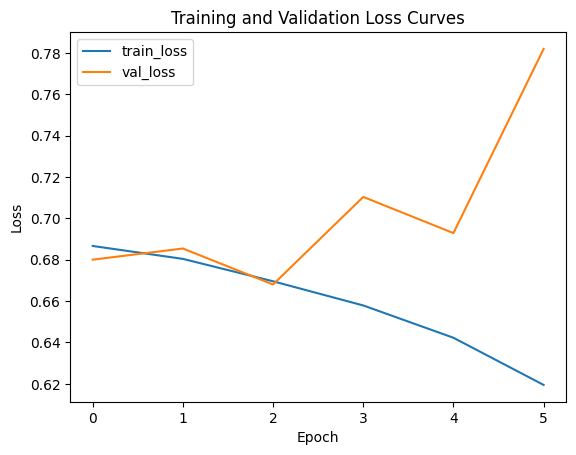

In [18]:
# set hyperparameters
lr = 1e-4
wd = 1e-5
num_epochs = 6

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define and train step 1 model
step1_cnn_model = Step1_ConvModel(lr, wd).to(device)
step1_cnn_model, step1_train_loss, step1_val_loss = train_model(step1_cnn_model, train_loader, val_loader, num_epochs,
                                                                opt = step1_cnn_model.configure_optimizers(),
                                                                save_path = "best_model_step1.pt", step1 = True)

# plot validation and training loss curves
plot_loss_curves(num_epochs, step1_train_loss, step1_val_loss)

 Saved new best model at epoch 1 with val_loss = 0.6845
 Saved new best model at epoch 2 with val_loss = 0.6453
 Saved new best model at epoch 3 with val_loss = 0.5872
 Saved new best model at epoch 4 with val_loss = 0.5069
 Saved new best model at epoch 5 with val_loss = 0.4187
 Saved new best model at epoch 6 with val_loss = 0.3501
 Saved new best model at epoch 7 with val_loss = 0.3135
 Saved new best model at epoch 8 with val_loss = 0.2978
 Saved new best model at epoch 9 with val_loss = 0.2936
 Saved new best model at epoch 10 with val_loss = 0.2919


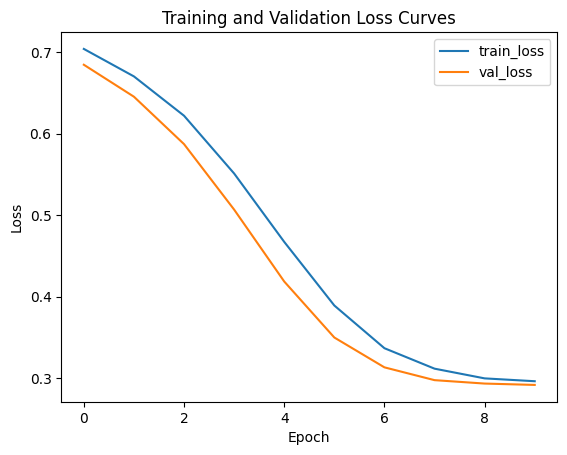

In [19]:
# hyperparameters
lr = 1e-4
wd = 1e-5
num_epochs = 10

# initialize step 2 model
step2_cnn_model = Step2_ConvModel(lr, wd, step1_cnn_model.feature_extractor).to(device)

# freeze CNN except last block
freeze_all_but_last_block(step2_cnn_model)

# build finetuned optimizer
finetuned_optimizer = build_finetune_optimizer(step2_cnn_model, lr = lr, wd = wd)

step2_cnn_model, step2_train_loss, step2_val_loss = train_model(step2_cnn_model, train_pos_loader, val_pos_loader, num_epochs,
                                                                opt = finetuned_optimizer, step1 = False,
                                                               save_path = "best_model_step2.pt")

# plot validation and training loss curves
plot_loss_curves(num_epochs, step2_train_loss, step2_val_loss)

# **Evaluate Model**

In [20]:
def model_eval(step1_model, step2_model, testloader, aneurysm_threshold = 0.5, location_threshold = 0.2):
    step1_model.eval()
    step2_model.eval()
    ys, probs_list, subj_list = [], [], [] # Use a list to store batches of test data

    with torch.no_grad():
        for tX, ty_any, ty_loc, tsubj in testloader:
            tX, ty_any, ty_loc, tsubj = tX.to(device), ty_any.to(device), ty_loc.to(device), tsubj.to(device)
            
            # forward pass in step 1
            step1_logits = step1_model.forward(tX)
            step1_prob = torch.sigmoid(step1_logits).squeeze(1)

            # fill out step 2 probs with 0s
            batch_size = tX.size(0)
            step2_dim = 13
            step2_probs = torch.zeros(batch_size, step2_dim, device = device)

            # which indices to run step 2
            idxs = (step1_prob > aneurysm_threshold).nonzero(as_tuple = True)[0]

            if len(idxs) > 0:
                tX_selected = tX[idxs]
                step2_logits = step2_model.forward(tX_selected)
                step2_probs_selected = torch.sigmoid(step2_logits)

                step2_probs[idxs] = step2_probs_selected   

            # combine probs and ys
            combined_probs = torch.cat((step2_probs, step1_prob.unsqueeze(1)), dim=1)
            combined_ys = torch.cat((ty_loc, ty_any.unsqueeze(1)), dim = 1)
            
            # Store
            ys.append(combined_ys.cpu().numpy())
            probs_list.append(combined_probs.cpu().numpy())
            subj_list.append(tsubj.cpu().numpy())
            
    ys = np.concatenate(ys, axis = 0)
    probs = np.concatenate(probs_list, axis = 0)
    subjects = np.concatenate(subj_list, axis = 0)

    # subject level aggregation
    from collections import defaultdict

    probs_by_subj = defaultdict(list)
    ys_by_subj = defaultdict(list)

    # put y, probs into subject oriented list
    for y, p, sid in zip(ys, probs, subjects):
        probs_by_subj[int(sid)].append(p)
        ys_by_subj[int(sid)].append(y)

    final_probs_subj = {}
    final_preds_subj = {}
    final_labels_subj = {}

    for sid in probs_by_subj.keys():
        subj_probs = np.stack(probs_by_subj[sid], axis = 0)
        subj_labels = np.stack(ys_by_subj[sid], axis = 0)

        final_prob_vec = np.zeros(14)
        final_pred_vec = np.zeros(14, dtype = int)
        final_label_vec = subj_labels.max(axis = 0).astype(int)
        
        for j in range(14):
            col_probs = subj_probs[:, j]

            # select threshold
            if j == 13:
                thr = aneurysm_threshold
            else:
                thr = location_threshold

            # apply max or average
            if np.any(col_probs > thr):
                final_prob = np.max(col_probs)
            else:
                final_prob = np.mean(col_probs)

            final_prob_vec[j] = final_prob
            final_pred_vec[j] = 1 if final_prob > 0.5 else 0

        final_probs_subj[sid] = final_prob_vec
        final_preds_subj[sid] = final_pred_vec
        final_labels_subj[sid] = final_label_vec

    # convert to arrays
    subj_ids_sorted = sorted(final_preds_subj.keys())

    probs_subj = np.stack([final_probs_subj[s] for s in subj_ids_sorted], axis = 0)
    preds_subj = np.stack([final_preds_subj[s] for s in subj_ids_sorted], axis = 0)
    ys_subj = np.stack([final_labels_subj[s] for s in subj_ids_sorted], axis = 0)
    
    print("****************************************************************************************")
    print("performance report")

    print(sklearn.metrics.classification_report(ys_subj, preds_subj, zero_division = 0))
    
    return ys_subj,preds_subj, probs_subj

def weighted_multiclass_roc_auc(Y_true, Y_prob, weights):
    n_classes = Y_true.shape[1]
    aucs = []
    
    for i in range(n_classes):
        try:
            auc = roc_auc_score(Y_true[:, i], Y_prob[:, i])
        except ValueError:
            auc = np.nan
        aucs.append(auc)
        
    aucs = np.array(aucs)

    valid = ~np.isnan(aucs)
    weighted_auc = np.sum(weights[valid] * aucs[valid]) / np.sum(weights[valid])

    return weighted_auc

In [21]:
weights = np.array([1/26]*13 + [.5])

# load best models
checkpoint1 = torch.load("best_model_step1.pt", map_location='cpu', weights_only = False)
checkpoint2 = torch.load("best_model_step2.pt", map_location='cpu', weights_only = False)

step1_cnn_model.load_state_dict(checkpoint1['model_state_dict'])
step2_cnn_model.load_state_dict(checkpoint2['model_state_dict'])

# get accuracy, classification report, weighted AUC
ys, preds, probs = model_eval(step1_cnn_model, step2_cnn_model, test_loader)

weighted_auc = weighted_multiclass_roc_auc(ys, probs, weights)
print(f"Weighted ROC AUC: {weighted_auc:.4f}")

****************************************************************************************
performance report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        27
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00        18
           3       0.00      0.00      0.00        11
           4       0.00      0.00      0.00        20
           5       0.00      0.00      0.00        12
           6       0.00      0.00      0.00        41
           7       0.00      0.00      0.00        54
           8       0.00      0.00      0.00        43
           9       0.00      0.00      0.00        28
          10       0.00      0.00      0.00         9
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00        73
          13       0.72      0.64      0.68       288

   micro avg       0.72      0.29      0.41       642
   macro avg       0.05   